In [1]:
from skimage.io import imread
from skimage.measure import regionprops
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import random
import re

r = lambda: random.randint(0,255)
random_color = lambda: f"#{r():02X}{r():02X}{r():02X}"

In [2]:
plt.rcParams["figure.dpi"] = 200

In [3]:
cycle_period = 0.0818

In [4]:
img_path = Path("../data/20230831/FOV2/Raster_2D_FOV2_5min_20230831_145108_DMD1_registered_affine.tif")
mip_path = Path("../data/20230831/FOV2/FOV2_Maxproj.tif")
mask_path = Path("../data/20230831/FOV2/FOV2_Labels2.tif")

img = imread(img_path)
mip = imread(mip_path)
mask = imread(mask_path)

acquiring_mins = re.findall("(\d+)min", img_path.stem)  # NOTE: check slap2->dataviewer
if acquiring_mins:
    cycle_period = int(acquiring_mins[0]) * 60 / img.shape[0]

In [5]:
time = cycle_period * np.arange(img.shape[0])

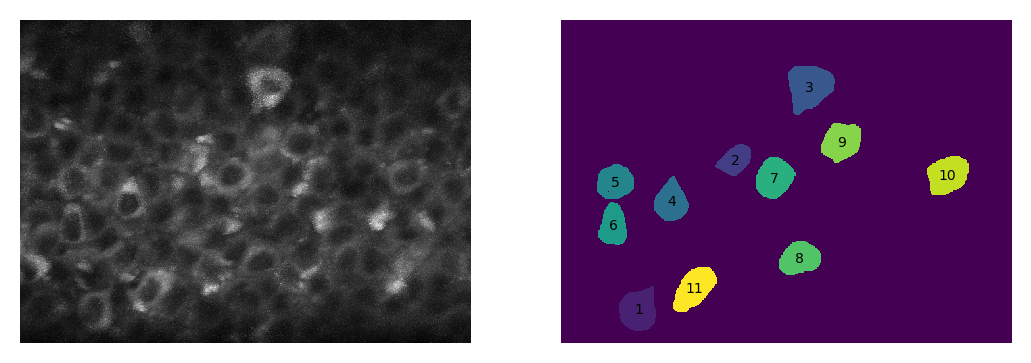

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(mip, interpolation="none", cmap="gray")
axes[1].imshow(mask, interpolation="none")

axes[0].axis("off")
axes[1].axis("off")


# add cell index
regions = regionprops(mask)
for (i, props) in enumerate(regions):
    y0, x0 = props.centroid
    axes[1].text(x0, y0, i+1, ha="center", va="center", size=5)

# Identify ROI edges

In [7]:
edges = np.zeros_like(mask)

for roi_index in np.unique(mask)[1:]:
    roi_mask = (mask == roi_index)

    # # outer edge
    # erosion_or_dilation = ndi.binary_dilation(roi_mask, iterations=7)  # increase iterations to make boundary wider!
    # 
    # # # inner edge
    # # erosion_or_dilation = ndi.binary_erosion(roi_mask, iterations=7)  # increase iterations to make boundary wider!
    # 
    # edge_mask = np.logical_xor(roi_mask, erosion_or_dilation)

    edge_mask = ndi.binary_dilation(roi_mask, iterations=7) & (~ndi.binary_fill_holes(roi_mask))  # in order to not show the inner hole of ROIs

    edges[edge_mask] = roi_index

# Select ROIs

In [21]:
roi_selected = np.array([1])

if roi_selected.size == 0:
    roi_selected = np.unique(mask)[1:]

In [22]:
edges_selected = edges.copy()

for roi in np.unique(edges)[1:]:
    if roi not in roi_selected:
        edges_selected[edges_selected==roi] = 0

for (i, roi) in enumerate(roi_selected):
    edges_selected[edges_selected==roi] = i+1

## Plot by random colors (all ROIs)

(-0.5, 685.5, 491.5, -0.5)

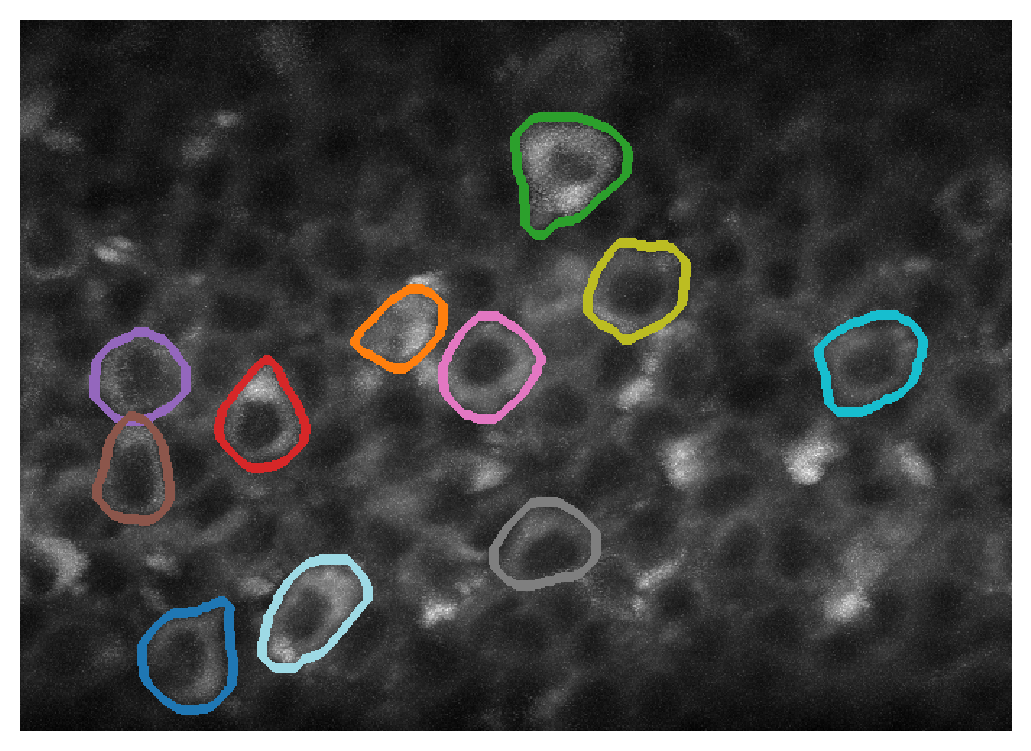

In [23]:
plt.imshow(mip, interpolation="none", cmap="gray")
plt.imshow(np.ma.array(edges, mask=(edges==0)), interpolation="none", cmap="tab20")
plt.gca().axis("off")

## Plot by custum colors

In [26]:
# color_list = ["red", (0.0, 0.0, 1.0), "#EEEEEE", random_color(), random_color(), random_color()]
color_list = [random_color() for i in range(len(roi_selected))]
print(color_list)

cmap = colors.ListedColormap(color_list)

assert ( cmap.N == (len(np.unique(edges_selected))-1) ), f"# of colors does not match {(len(np.unique(edges_selected))-1)} of ROIs"

bounds = [0.5+i for i in range(cmap.N+1)]
norm = colors.BoundaryNorm(bounds, cmap.N)

['#7BB1EE']


(-0.5, 685.5, 491.5, -0.5)

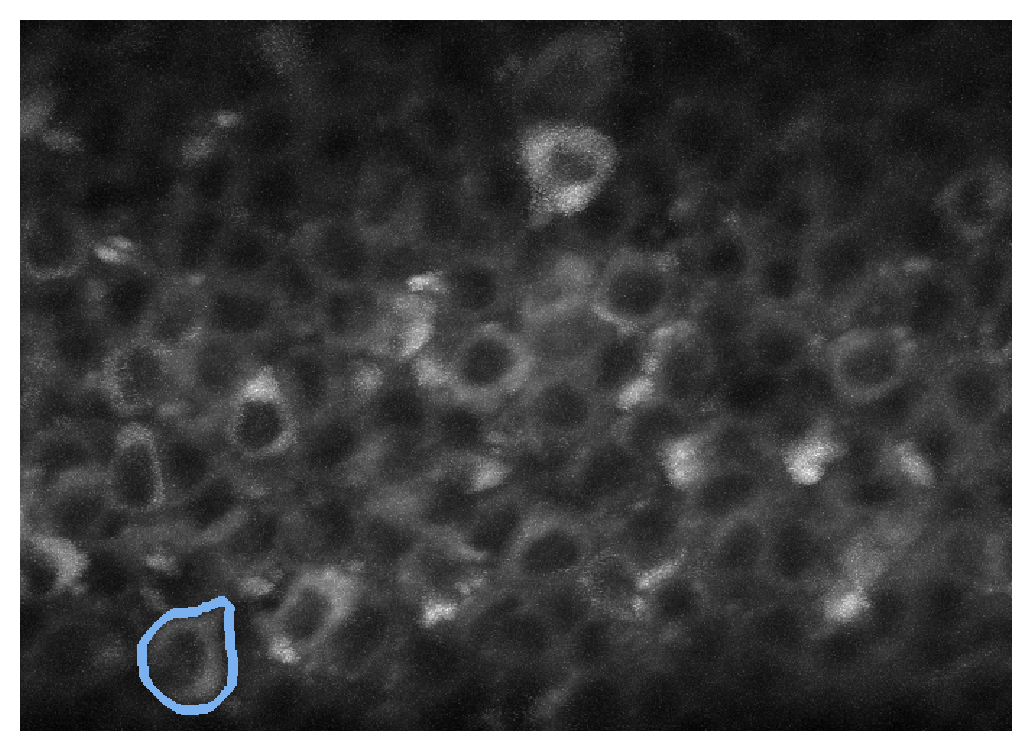

In [27]:
plt.imshow(mip, interpolation="none", cmap="gray")
plt.imshow(np.ma.array(edges_selected, mask=(edges_selected==0)), interpolation="none", cmap=cmap, norm=norm)
plt.gca().axis("off")

# Fluorescence traces

In [13]:
n_roi = len(np.unique(mask)) - 1
t_step = img.shape[0]

raw_f = np.zeros((n_roi, t_step))
baseline = np.zeros(n_roi)
dff = np.zeros((n_roi, t_step))

for (i, cell_id) in enumerate(np.unique(mask)[1:]):
    roi_mask = (mask==cell_id)
    roi_value = img[:, roi_mask]
    f = np.mean(roi_value, axis=1)
    f0 = np.median(f)

    raw_f[i, :] = f
    baseline[i] = f0
    dff[i, :] = (f - f0) / f0

Text(0.5, 0, 'Time (s)')

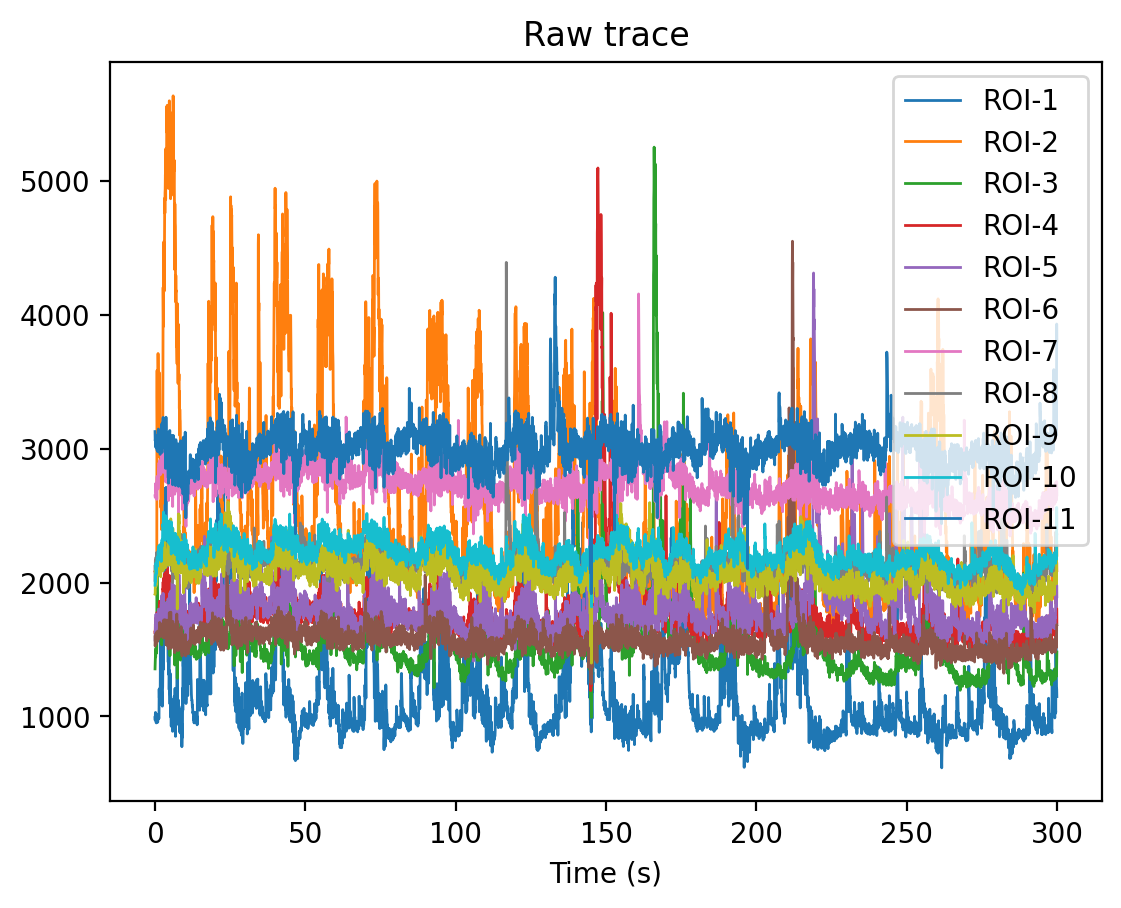

In [14]:
for i in range(n_roi):
    plt.plot(time, raw_f[i], label=f"ROI-{i+1}", lw=1.0)

plt.legend()
plt.title("Raw trace")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

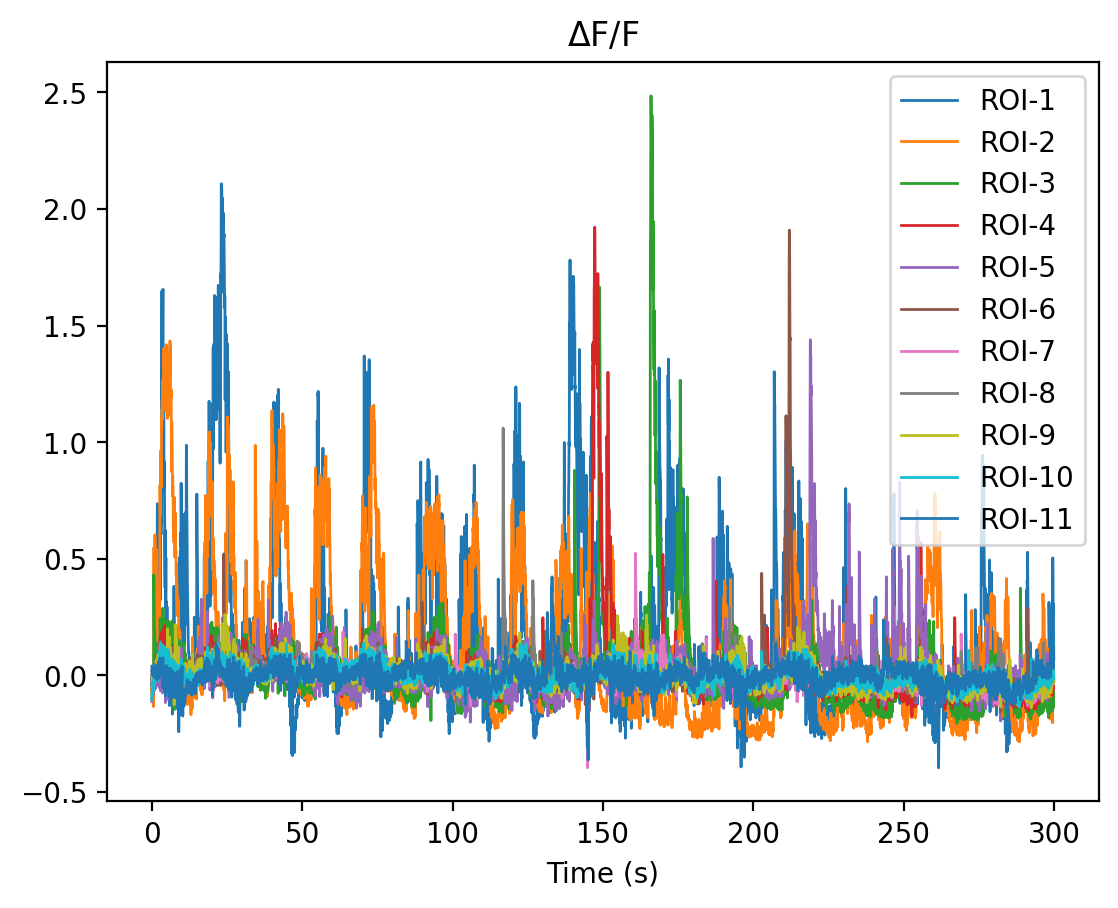

In [15]:
for i in range(n_roi):
    plt.plot(time, dff[i], label=f"ROI-{i+1}", lw=1.0)

plt.legend()
plt.title(r"$\Delta$F/F")
plt.xlabel("Time (s)")

Text(0.5, 1.0, '$\\Delta$F/F')

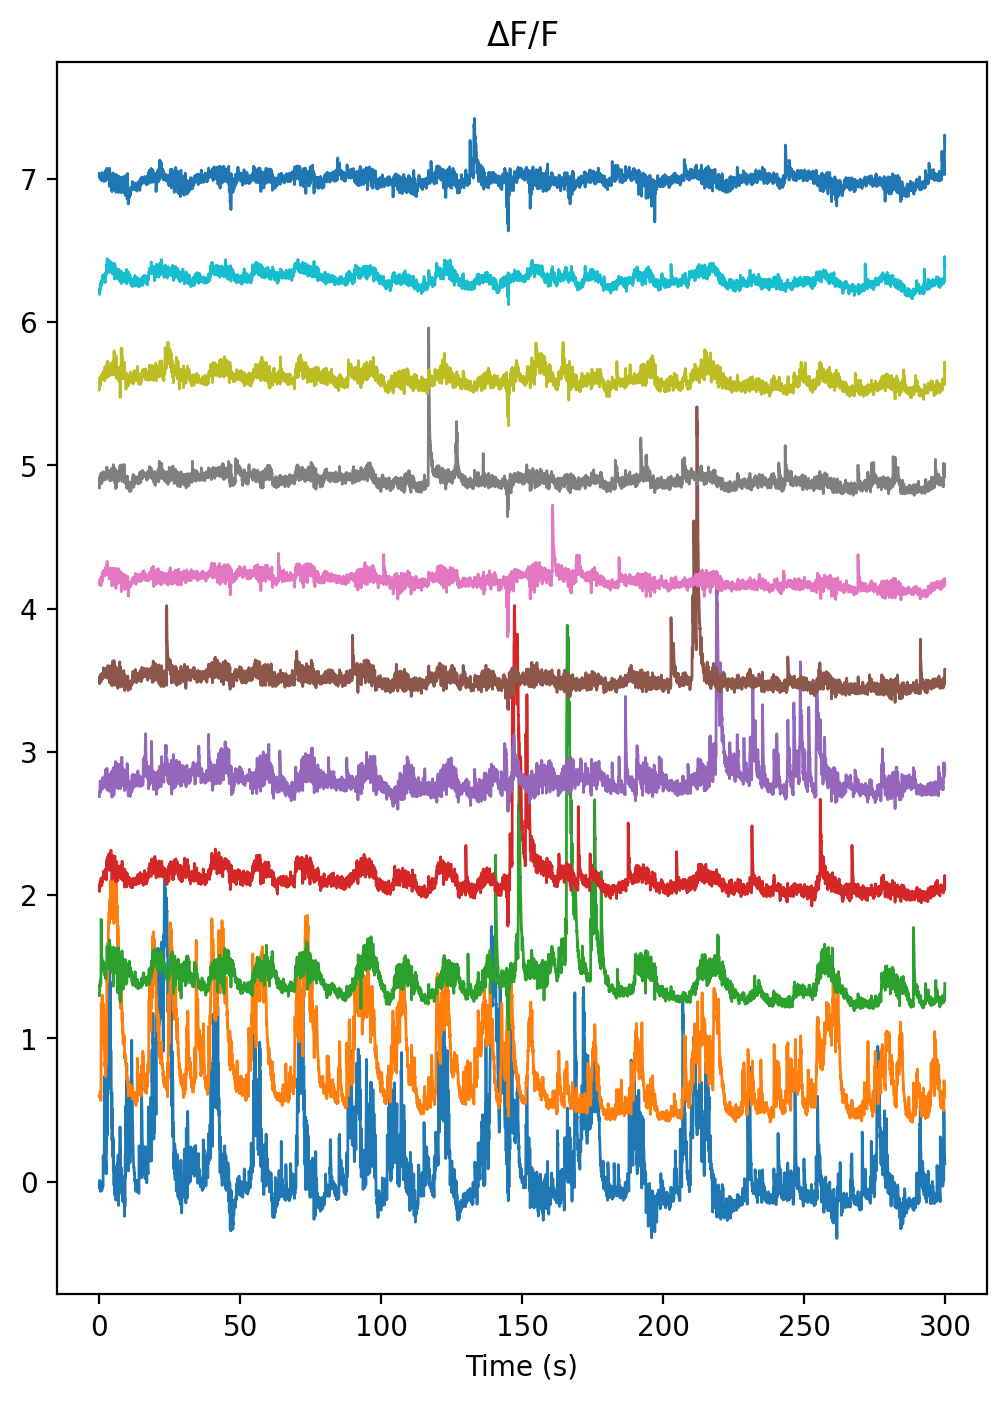

In [16]:
plt.figure(figsize=(6, 8))

for (i, trace) in enumerate(dff):
    plt.plot(time, dff[i] + 0.7*i, lw=1.0)

# plt.yticks([])
plt.xlabel("Time (s)")
plt.title(r"$\Delta$F/F")

In [17]:
plot_style = {
    "axes.linewidth": 2,
    "xtick.major.size": 5,
    "xtick.major.width": 2,
    "xtick.labelsize": 14
}

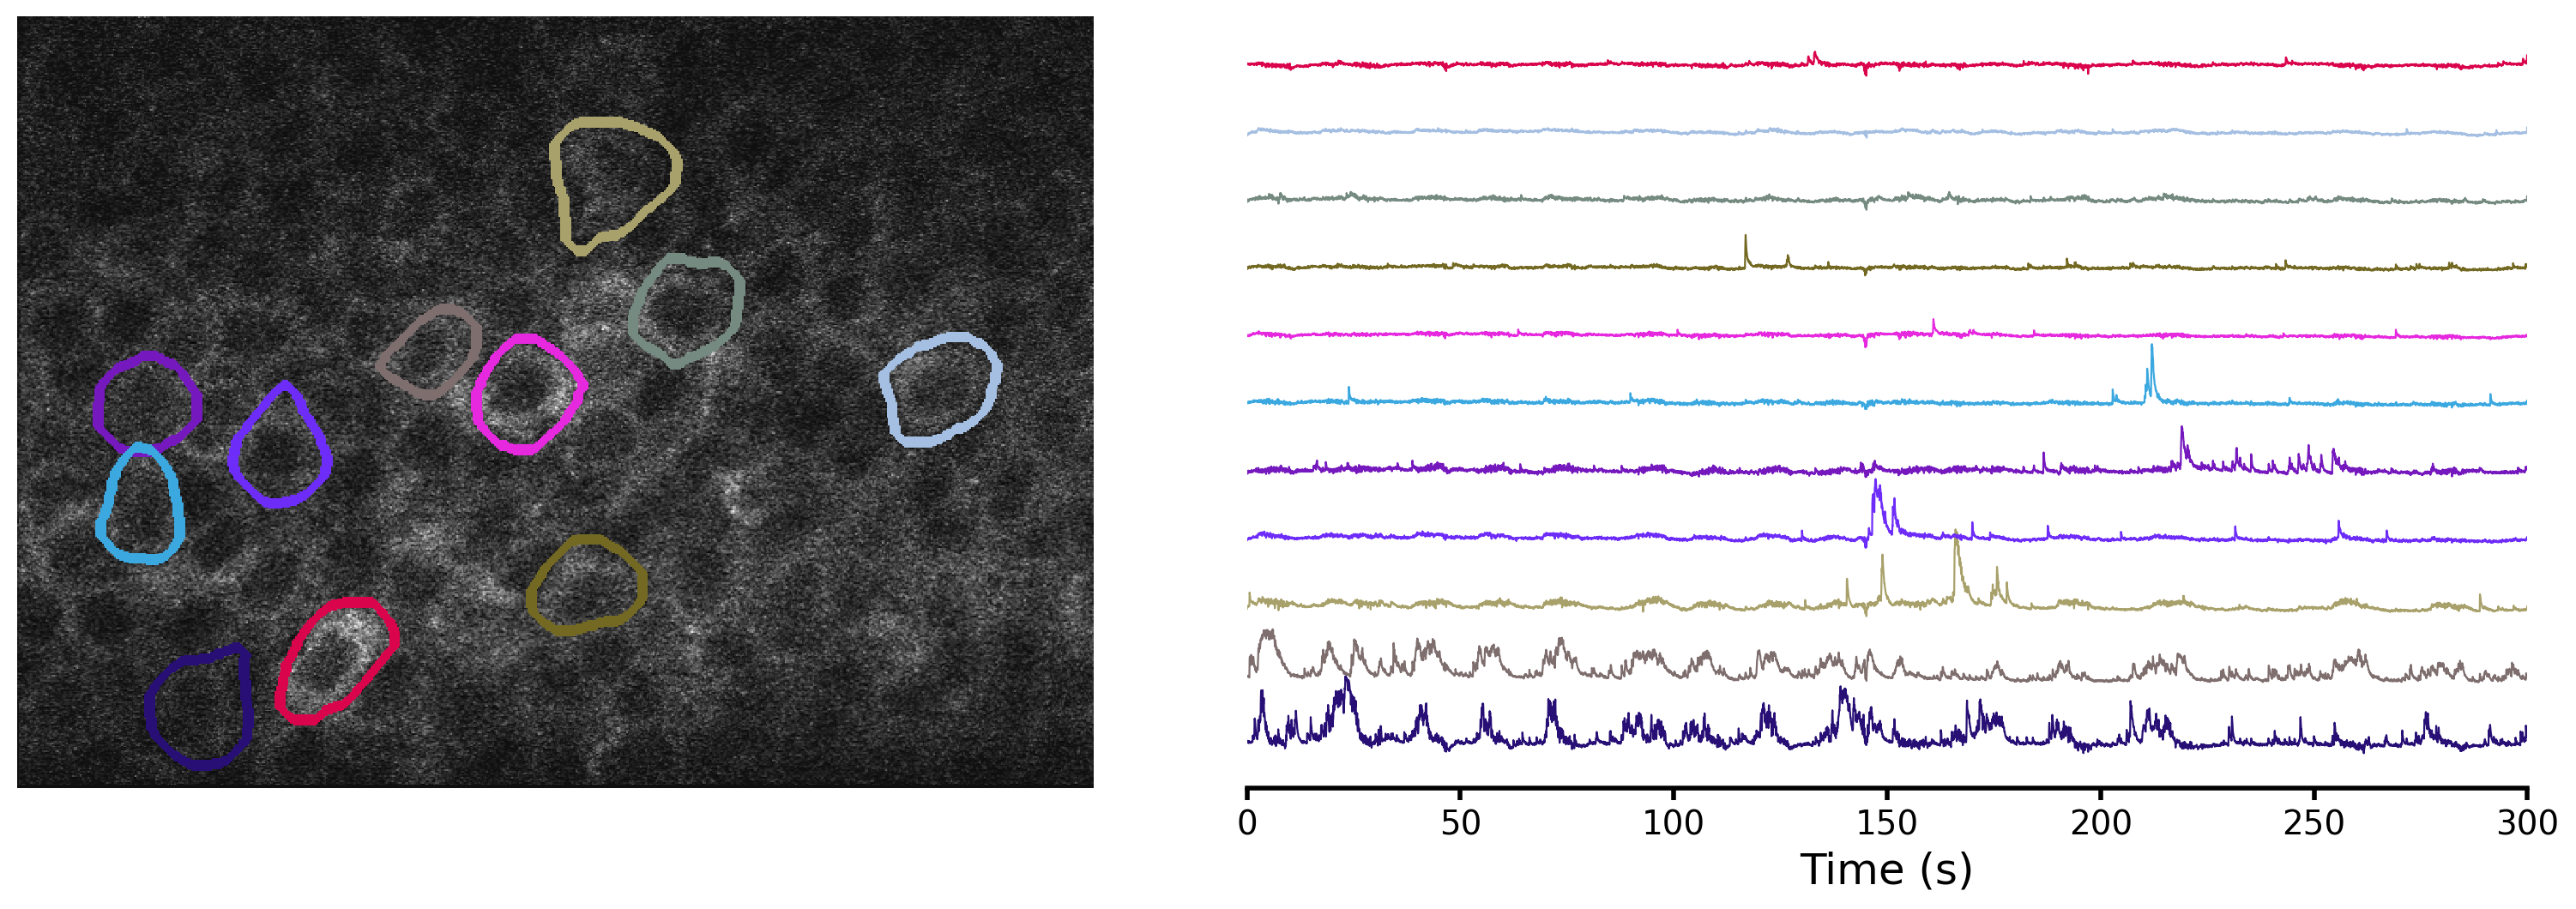

In [20]:
min_val = None
max_val = None

trace_space = 2.2

with mpl.rc_context(plot_style):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.tight_layout()
    fig.subplots_adjust(
        top=0.8,
        bottom=0.05,
        # left=0.05,
        # right=0.98,
        # hspace=0.2,
        wspace=0.04
    )

    axes[0].imshow(img[0], cmap="gray", interpolation="none", vmin=min_val, vmax=max_val)
    axes[0].imshow(np.ma.array(edges_selected, mask=(edges_selected==0)), interpolation="none", cmap=cmap, norm=norm)
    axes[0].axis("off")

    for (i, roi) in enumerate(roi_selected):
        axes[1].plot(time, dff[roi-1] + trace_space*i, color=color_list[i], lw=0.8)

    axes[1].spines[["left", "right", "top"]].set_visible(False)
    axes[1].set_yticks([])
    axes[1].set_xlim([0, round(time[-1])])
    axes[1].set_xlabel("Time (s)", size=18)

    plt.show()

In [19]:
header = [f"ROI{i+1}" for i in range(dff.shape[0])]

traces = pd.DataFrame(dff.transpose())
traces.columns = header
traces = traces.round(8)
traces.insert(0, "Time", time)
traces.to_csv(f"{img_path.parent}/{img_path.stem}_traces.csv", index=False)